In [73]:
import torch
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load data and predictions
x = # input data
y = # true locations
y_hat = # predictions

n, m = [*y.shape]

SyntaxError: invalid syntax (<ipython-input-2-9650b644fcf0>, line 2)

In [ ]:
# define d to be either interocular distance or bounding box diagonal length
d = 

In [ ]:
""" Accuracy Metrics: Normalized Mean Error (NME) and CED/AUC/FR
y, y_hat have dimensions of num_samples x (2*num_features)
d is the interocular distance
"""
# returns the NME of each image in the dataset
def nme(y_hat, y, m, d):
    return torch.square(torch.norm(y_hat-y, dim=1))/ d / m

# returns the average NME across all images
def total_nme(nme):
    return torch.mean(NME)

# outputs the CED
def ced(nme):
    x = torch.sort(NME)
    y = np.arange(n) / float(n)
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
  
    plt.title('Plot of NME vs Fraction of Samples')
    plt.plot(x, y, marker='o')
    plt.show

# returns the percentage of samples with nme=0 to alpha
def auc(nme, alpha):
    x = torch.where(NME < alpha, 1, 0)
    return torch.sum(failure) / n
    
# returns the failure rate, where failure is defined w.r.t a threshold, alpha (percent of samples with nme>alpha)
def fr(nme, alpha):
    return 1-auc(nme, alpha)

In [ ]:
nme = nme(y_hat, y, m, d)
total_nme = total_nme(nme)

In [ ]:
ced = ced(nme)

In [ ]:
"""Bias Metrics: Majority/Minority Difference (MMD), Improvement Over the Standard Model (IOSM), KL-divergence
g = sensitive attribute group (as column number)
maj = value of minority group
nme = num_samples dimension tensor
"""

def mmd(g, maj, nme, data):
    acc = 1-nme
    majority = acc[tensor.where(data[:, g] == maj)]
    minority = acc[tensor.where(data[:, g] != maj)]
    difference = torch.mean(majority) - torch.mean(minority)
    return difference

# def iosm(g, nme, )

# def KL divergence(g, maj, nme, data):


# Model Evaluation

In [34]:
import os
import torch
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from torch import nn
from tqdm import tqdm

import sys
sys.path.append('../src/data')
sys.path.append('../src/')
sys.path.append('../src/utils')

from datasets import CelebaDataset
import landmark_transforms
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from trainer import Trainer

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cuda


In [60]:
def generate_predictions(model,
                         dataloader,
                         forward_args = {},
                         numclasses = 5*2,
                         device = torch.device('cuda')):
    y_pred = np.zeros((0,int(numclasses/2), 2))
    y = np.zeros((0,int(numclasses/2), 2))
    
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader)):
            inputs = batch['image'].to(device=device)
            labels = batch['landmarks'].numpy()

            outputs = model(inputs, **forward_args).cpu().view(-1, int(numclasses/2), 2).numpy()  # (batch_size, length, num_classes)
            
            y_pred = np.concatenate((y_pred, outputs), axis=0)
            y = np.concatenate((y, labels), axis=0)
                
    return y_pred, y

## Evaluate CelebA

In [7]:
celeba_data_loc = '/home/data/celeba/'

train_dataset = CelebaDataset(celeba_data_loc + 'landmarks_train.csv', celeba_data_loc + 'attr_train.csv', celeba_data_loc + 'images',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]))
val_dataset = CelebaDataset(celeba_data_loc + 'landmarks_val.csv', celeba_data_loc + 'attr_val.csv', celeba_data_loc + 'images',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]))
test_dataset = CelebaDataset(celeba_data_loc + 'landmarks_test.csv', celeba_data_loc + 'attr_test.csv', celeba_data_loc + 'images',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]))

trainloader_params = {
    'dataset': train_dataset,
    'batch_size': 8,
    'shuffle': False
}
train_dataloader = DataLoader(**trainloader_params)

valloader_params = {
    'dataset': val_dataset,
    'batch_size': 4,
    'shuffle': False
}
val_dataloader = DataLoader(**valloader_params)

testloader_params = {
    'dataset': test_dataset,
    'batch_size': 4,
    'shuffle': False
}
test_dataloader = DataLoader(**testloader_params)

In [9]:
# Outputs model checkpoints
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints"

celeba_baseline_resnet_1/             wflw_baseline_resnet_pretrain_1/
celeba_baseline_resnet_nopretrain_1/  wflw_baseline_resnet_pretrain_2/
celeba_baseline_simplenet_1/          wflw_baseline_simplenet_1/
wflw_baseline_resnet_nopretrain_1/


In [15]:
# View model to evaluate
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/celeba_baseline_resnet_1/"

checkpoint_0/  checkpoint_1/  checkpoint_2/


In [16]:
model_path = "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/celeba_baseline_resnet_1/checkpoint_2/model.pt"
model = torch.load(model_path).to(device)

In [61]:
y_pred, y = generate_predictions(model, test_dataloader, numclasses=5*2, device=device)

  0%|          | 4/4991 [00:00<05:02, 16.49it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  0%|          | 8/4991 [00:00<05:18, 15.66it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  0%|          | 12/4991 [00:00<04:59, 16.61it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  0%|          | 14/4991 [00:00<05:14, 15.84it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  0%|          | 18/4991 [00:01<05:28, 15.14it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  0%|          | 20/4991 [00:01<05:21, 15.45it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  0%|          | 22/4991 [00:01<06:56, 11.94it/s]

torch.Size([4, 3, 224, 224])


  0%|          | 24/4991 [00:01<08:38,  9.57it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  1%|          | 28/4991 [00:02<07:58, 10.38it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  1%|          | 30/4991 [00:02<14:18,  5.78it/s]

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])


  1%|          | 31/4991 [00:03<08:04, 10.23it/s]

torch.Size([4, 3, 224, 224])


KeyboardInterrupt: 

In [112]:
data_dict = {
    'y': y.flatten(),
    'y_pred': y_pred.flatten()
}

pred_df = pd.DataFrame(data_dict)
results_csv_path = model_path.replace('model.pt', f'results.csv')
pred_df.to_csv(results_csv_path)

# Print CelebA predictions

In [107]:
def show_landmarks(image, landmarks, norm=True):
    """Show image with landmarks"""
    if norm:
        inv_normalize = transforms.Normalize(
           mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
           std=[1/0.229, 1/0.224, 1/0.225]
        )
        image = inv_normalize(image)
    
    plt.imshow(transforms.ToPILImage()(image))
    plt.scatter(landmarks[:, 0] * image.shape[-1], landmarks[:, 1] * image.shape[-2], s=20, marker='.', c='b')
    plt.pause(0.001)  # pause a bit so that plots are updated

Pred


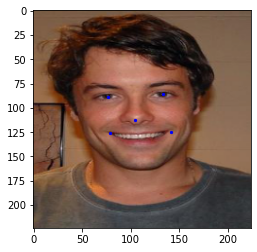

Truth


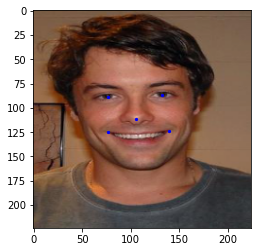

In [120]:
img_num = 130

plt.figure()
sample = test_dataset[img_num]
print('Pred')
show_landmarks(sample['image'], y_pred[img_num])
print('Truth')
show_landmarks(sample['image'], y[img_num])
plt.show()